### 缺失数据处理

In [1]:
%matplotlib inline

import pandas as pd
from io import StringIO

csv_data = '''A,B,C,D
1.0,2.0,3.0,4.0
5.0,6.0,,8.0
10.0,11.0,12.0,'''
#En Python 2.7 habría que convertirlo a unicode csv_data=unicode(csv_data)
df = pd.read_csv(StringIO(csv_data))
df

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


In [2]:
df.isnull().sum()

A    0
B    0
C    1
D    1
dtype: int64

In [3]:
df.values

array([[  1.,   2.,   3.,   4.],
       [  5.,   6.,  nan,   8.],
       [ 10.,  11.,  12.,  nan]])

In [4]:
df.dropna()

,A,B,C,D
0,1.0,2.0,3.0,4.0


In [5]:
df.dropna(axis=1)

,A,B
0,1.0,2.0
1,5.0,6.0
2,10.0,11.0


In [6]:
# Only drop rows where all columns are NaN
df.dropna(how='all')

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


In [7]:
# Drop rows that have not at least 4 non-NaN values
df.dropna(thresh=4)

,A,B,C,D
0,1.0,2.0,3.0,4.0


In [8]:
# Only drop rows where NaN appear in specific columns (here 'C')
df.dropna(subset=['C'])

,A,B,C,D
0,1.0,2.0,3.0,4.0
2,10.0,11.0,12.0,NaN


In [9]:
from sklearn.preprocessing import Imputer

# 插入平均值，axis可以选择是插入行的还是列的
imr = Imputer(missing_values='NaN', strategy='mean', axis=0) 
imr = imr.fit(df)
imputed_data = imr.transform(df.values)
imputed_data

array([[  1. ,   2. ,   3. ,   4. ],
       [  5. ,   6. ,   7.5,   8. ],
       [ 10. ,  11. ,  12. ,   6. ]])

### 处理类别数据

In [10]:
import pandas as pd
df = pd.DataFrame([
        ['green','M',10.1,'class1'],
        ['red','L',13.5,'class2'],
        ['blue','XL',15.3,'class1']
    ])
df.columns = ['color','size','price','classlabel']
df

,color,size,price,classlabel
0,green,M,10.1,class1
1,red,L,13.5,class2
2,blue,XL,15.3,class1


In [11]:
# 用字典做数据映射
size_mapping = {'XL': 3, 'L':2, 'M':1}
df['size'] = df['size'].map(size_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,class1
1,red,2,13.5,class2
2,blue,3,15.3,class1


In [12]:
inv_size_mapping = {v:k for k,v in size_mapping.items()}
inv_size_mapping

{1: 'M', 2: 'L', 3: 'XL'}

In [13]:
import numpy as np
# 将classlabel字段做映射
class_mapping = {label:idx for idx,label in enumerate(np.unique(df['classlabel']))}
class_mapping

{'class1': 0, 'class2': 1}

In [14]:
df['classlabel'] = df['classlabel'].map(class_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,0
1,red,2,13.5,1
2,blue,3,15.3,0


In [15]:
# 使用相反字典来还原数据
inv_class_mapping = {v:k for k,v in class_mapping.items()}
df['classlabel'] = df['classlabel'].map(inv_class_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,class1
1,red,2,13.5,class2
2,blue,3,15.3,class1


In [16]:
# 使用sklearn的LabelEncoder可以很方便的完成泪飙的整数编码工作
from sklearn.preprocessing import LabelEncoder
class_le = LabelEncoder()
y = class_le.fit_transform(df['classlabel'].values)
y

array([0, 1, 0], dtype=int64)

In [17]:
# 还原原始字符串
class_le.inverse_transform(y)

array(['class1', 'class2', 'class1'], dtype=object)

In [18]:
X = df[['color', 'size', 'price']].values
color_le = LabelEncoder()
# 将color同样的处理转换成数字编码
X[:, 0] = color_le.fit_transform(X[:, 0])
# 这里将颜色转换成了数字0，1，2，这样的话算法会认为颜色是有大小关系的，这样也能得到结果，但是可能不是最优解。
# 下面有更好的替代品，one-hat encoding
X

array([[1, 1, 10.1],
       [2, 2, 13.5],
       [0, 3, 15.3]], dtype=object)

In [19]:
from sklearn.preprocessing import OneHotEncoder
# one-hat encoding 这里我们将颜色转换成3个新的特征，blue、green、red。
ohe = OneHotEncoder(categorical_features=[0])
ohe.fit_transform(X).toarray()

array([[  0. ,   1. ,   0. ,   1. ,  10.1],
       [  0. ,   0. ,   1. ,   2. ,  13.5],
       [  1. ,   0. ,   0. ,   3. ,  15.3]])

In [20]:
# get_dummies更加方便的返回one-hat数据，get_dummies只对字符串列进行转换，其他列不变。
pd.get_dummies(df[['price','color','size']])

,price,size,color_blue,color_green,color_red
0,10.1,1,0,1,0
1,13.5,2,0,0,1
2,15.3,3,1,0,0


### 将数据集划分为训练集和测试集

In [21]:
# 借助pandas，直接从UCI机器学习样本数据库导入开源的葡萄酒数据。数据为178个样本的13个不同的特征。
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium','Total phenols',
                  'Flavanoids','Nonflavanoid phenols','Proanthocyanins','Color intensity', 'Hue', 
                   'OD280/OD315 of diluted wines', 'Proline']
print('Class labels',np.unique(df_wine['Class label']))

Class labels [1 2 3]


In [22]:
df_wine.head()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


### 特征缩放

In [23]:
from sklearn.model_selection import train_test_split
X, y = df_wine.iloc[:, 1:].values,df_wine.iloc[:, 0].values
# 将数据3、7分为训练数据和测试数据
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [24]:
from sklearn.preprocessing import MinMaxScaler
# 特征缩放，使用最小-最大缩放 (x(i) - x_min） / （x_max - x_min） 
mms = MinMaxScaler()
X_train_norm = mms.fit_transform(X_train)
X_test_norm = mms.transform(X_test)
X_test_norm[0]

array([ 0.72849462,  0.16386555,  0.47849462,  0.29896907,  0.52173913,
        0.53956835,  0.74311927,  0.13461538,  0.37974684,  0.4364852 ,
        0.32478632,  0.70695971,  0.60566802])

In [25]:
from sklearn.preprocessing import StandardScaler
# 使用标准化进行缩放 (x(i) - 均值) / 标准差
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)
X_test_std[0]

array([ 0.94841977, -0.63042822, -0.4110476 , -0.87677804,  1.22679643,
        0.57147571,  0.95620726, -1.24682729,  0.01258759,  0.36299992,
       -0.15283642,  0.83141032,  1.01828164])

### 选择有意义的特征

In [26]:
from sklearn.linear_model import LogisticRegression

# 使用l1正则化来稀疏数据，并添加正则化值，值越小正则化效果越大。
lr = LogisticRegression(penalty='l1', C=0.1)  
lr.fit(X_train_std, y_train)
print('Training accuracy: ', lr.score(X_train_std, y_train))
print('Test accuracy: ', lr.score(X_test_std, y_test))
# 训练和测试精准度均为98%，未出现过拟合。

Training accuracy:  0.983870967742
Test accuracy:  0.981481481481


In [27]:
# 显示截距项
lr.intercept_

array([-0.38383759, -0.15806746, -0.70038052])

In [28]:
# 显示权重系数向量
lr.coef_

array([[ 0.28024065,  0.        ,  0.        , -0.02801218,  0.        ,
         0.        ,  0.71011461,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.2360573 ],
       [-0.64405099, -0.06880813, -0.05720927,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.92666968,
         0.06019101,  0.        , -0.37100142],
       [ 0.        ,  0.06134455,  0.        ,  0.        ,  0.        ,
         0.        , -0.6370015 ,  0.        ,  0.        ,  0.49850222,
        -0.35819407, -0.57038282,  0.        ]])

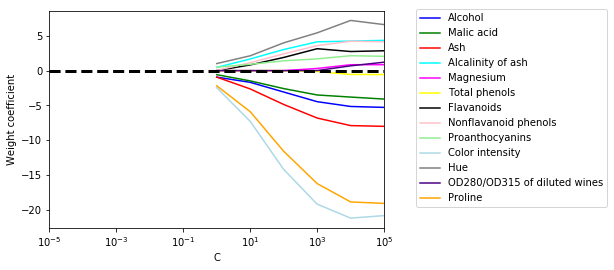

In [29]:
import matplotlib.pyplot as plt
# 绘制正则化的效果图，选择不同的正则化参数，看权重系数的变化。
fig = plt.figure()
ax = plt.subplot(111)
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'pink', 'lightgreen', 'lightblue',
         'gray', 'indigo', 'orange']
weights, params = [], []
for c in np.arange(0, 6):
    lr = LogisticRegression(penalty='l1', C=10**c, random_state=0)
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10**c)
weights = np.array(weights)
for column, color in zip(range(weights.shape[1]), colors):
    plt.plot(params, weights[:, column], label=df_wine.columns[column+1], color=color)

plt.axhline(0, color='black', linestyle='--', linewidth=3)
plt.xlim([10**-5, 10**5])
plt.ylabel('Weight coefficient')
plt.xlabel('C')
plt.xscale('log')
plt.legend(loc='upper left')
ax.legend(loc='upper center', bbox_to_anchor=(1.38,1.03), ncol=1, fancybox=True)
plt.show()
# 可以看到在强的正则化参数（C<0.1）作用下，惩罚使得所有的特征权重都趋近于0.这里C是正则化参数入的倒数。

In [30]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
# SBS算法思想：SBS一次从特征集合中删除某些特征，直到新的特征子空间包含指定数量的特征。为了确定每一步中所需删除的特征，
# 我们定义一个需要最小化的标准衡量函数J。为了达到每一步特征被删除后，所引起的模型性能损失最小。

class SBS():
    def __init__(self, estimator, k_features, scoring=accuracy_score, test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = estimator
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state
    
    def fit(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.test_size, random_state=self.random_state)
        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, X_test, y_test, self.indices_)
        self.scores_ = [score]
        
        while dim > self.k_features:
            scores = []
            subsets = []
            for p in combinations(self.indices_, r=dim-1):
                score = self._calc_score(X_train, y_train, X_test, y_test, p)
                scores.append(score)
                subsets.append(p)
                
            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1
            # 添加表现最好的，然后继续循环
            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]
        
        return self
    
    def transform(self,X):
        return X[:, self.indices_]
    
    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

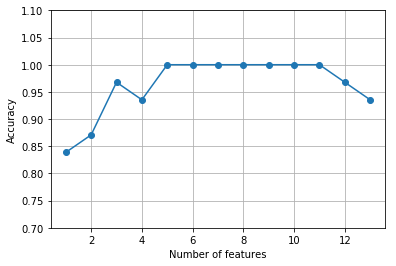

In [31]:
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
# 使用KNN分类器来看看SBS的效果
knn = KNeighborsClassifier(n_neighbors=2)
sbs = SBS(knn, k_features=1)
sbs.fit(X_train_std, y_train)

k_feat = [len(k) for k in sbs.subsets_]
plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.1])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.show()
# 从图中可以看到当特征数为5-10时，准确率为100%

In [32]:
# 打印出表现最好的5个特征
k5 = list(sbs.subsets_[8])  
print(df_wine.columns[1:][k5])

Index(['Alcohol', 'Malic acid', 'Alcalinity of ash', 'Hue', 'Proline'], dtype='object')


In [33]:
# KNN在原始数据上的表现
knn.fit(X_train_std, y_train)
print('Training accuracy: ', knn.score(X_train_std, y_train))
print('Test accuracy: ', knn.score(X_test_std, y_test))
# 可以看到模型有点过拟合

Training accuracy:  0.983870967742
Test accuracy:  0.944444444444


In [34]:
# 只选定5个特征的表现
knn.fit(X_train_std[:, k5],y_train)
print('Training accuracy: ', knn.score(X_train_std[:,k5], y_train))
print('Test accuracy: ', knn.score(X_test_std[:, k5], y_test))
# 可以看到过拟合已经缓解

Training accuracy:  0.959677419355
Test accuracy:  0.962962962963


In [35]:
# 选取6个特征
k6 = list(sbs.subsets_[7])  
knn.fit(X_train_std[:, k6],y_train)
print('Training accuracy: ',knn.score(X_train_std[:, k6],y_train))
print('Test accuracy: ',knn.score(X_test_std[:, k6],y_test))

Training accuracy:  0.975806451613
Test accuracy:  1.0


### 通过随机森林判定特征的重要性

In [36]:
from sklearn.ensemble import RandomForestClassifier

feat_labels = df_wine.columns[1:]
forest = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)
forest.fit(X_train, y_train)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f+1, 30, feat_labels[indices[f]], importances[indices[f]]))

 1) Color intensity                0.182483
 2) Proline                        0.158610
 3) Flavanoids                     0.150948
 4) OD280/OD315 of diluted wines   0.131987
 5) Alcohol                        0.106589
 6) Hue                            0.078243
 7) Total phenols                  0.060718
 8) Alcalinity of ash              0.032033
 9) Malic acid                     0.025400
10) Proanthocyanins                0.022351
11) Magnesium                      0.022078
12) Nonflavanoid phenols           0.014645
13) Ash                            0.013916


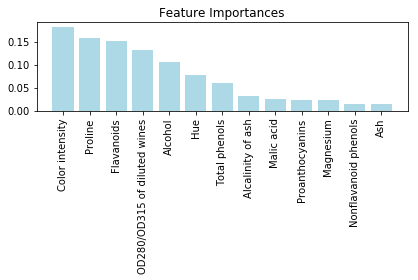

In [37]:
plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]), importances[indices], color='lightblue', align='center')
plt.xticks(range(X_train.shape[1]), feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()
# 特征的重要性经过归一化处理过了，其和为1.

In [38]:
from sklearn.feature_selection import SelectFromModel
# 可以通过我们上面的随机森林然后将阈值设置成0.14可以将数据集压缩到三个最重要的特征。
selected = SelectFromModel(forest, threshold=0.14, prefit=True)
X_selected = selected.transform(X_train)
X_selected.shape

(124, 3)